In [21]:
import pandas as pd 
import plotnine as p9   
import numpy as np
import glob

In [22]:
path = "Simulations/results/car"
all_file = glob.glob(path + "/*.csv")
print(len(all_file))

dfs = [pd.read_csv(f) for f in all_file]
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.keys(), "\n", combined_df.shape, "\n", combined_df.dtypes)

37
Index(['idx', 'model', 'estimand', 'gamma_noise', 'mean', 'median', 'true',
       'bias', 'std', 'RMSE', 'RMSE_rel', 'MAE', 'MAPE', 'q025', 'q975',
       'covering', 'mean_ind_cover', 'w_dist'],
      dtype='object') 
 (14948, 18) 
 idx               object
model             object
estimand          object
gamma_noise       object
mean              object
median            object
true              object
bias              object
std               object
RMSE              object
RMSE_rel          object
MAE               object
MAPE              object
q025              object
q975              object
covering          object
mean_ind_cover    object
w_dist            object
dtype: object


In [23]:
# to numeric
numeric_columns = combined_df.keys()[3:]

for col in numeric_columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

print(combined_df.dtypes)

# combined_df["gamma_noise"] = pd.to_numeric(combined_df["gamma_noise"], errors='coerce')
# combined_df["mean"] = pd.to_numeric(combined_df["mean"], errors='coerce')
# combined_df["std"] = pd.to_numeric(combined_df["std"], errors='coerce')

idx                object
model              object
estimand           object
gamma_noise       float64
mean              float64
median            float64
true              float64
bias              float64
std               float64
RMSE              float64
RMSE_rel          float64
MAE               float64
MAPE              float64
q025              float64
q975              float64
covering          float64
mean_ind_cover    float64
w_dist            float64
dtype: object


In [24]:
# get unique iteration idx
idx_split = combined_df['idx'].str.split('_', expand=True)
combined_df["iteration"] = idx_split[0] + "_" + idx_split[1]
combined_df[["idx", "iteration"]]

,idx,iteration
0,1_0_0,1_0
1,1_0_0,1_0
2,1_0_0,1_0
3,1_0_0,1_0
4,1_0_0,1_0
...,...,...
14943,9_9_4,9_9
14944,9_9_4,9_9
14945,9_9_4,9_9
14946,9_9_4,9_9


In [25]:
mask_id = (
    # (combined_df["model"] == "MWG") &
    (combined_df["model"] == "MWG_rep") &
    (combined_df["estimand"] == "dynamic") &
    (combined_df["gamma_noise"] == 2.0)
)
mwg_df = combined_df[mask_id]
top_iterations = (
    mwg_df.groupby("iteration")["RMSE_rel"].max()
    .nsmallest(333)
    .reset_index()
)
top_iterations
# top_iterations["iteration"].values

,iteration,RMSE_rel
0,11_1,0.02877
1,13_0,0.03223
2,13_4,0.03964
3,14_5,0.04122
4,6_3,0.04158
...,...,...
328,6_6,0.19957
329,9_1,0.20125
330,17_9,0.20303
331,27_0,0.20303


In [26]:
filtered_df = combined_df[combined_df["iteration"].isin(top_iterations["iteration"].values)]

print(filtered_df.head(10))
print(filtered_df.shape)

     idx     model estimand  gamma_noise     mean   median     true     bias  \
0  1_0_0  true_net  dynamic          2.0  3.59598  3.10199  3.58301  0.01298   
1  1_0_0  true_net    stoch          2.0  5.24175  5.04176  5.22285  0.01890   
2  1_0_0   obs_net  dynamic          2.0  0.95150  0.26581  3.58301 -2.63150   
3  1_0_0   obs_net    stoch          2.0  1.34247  1.33795  5.22285 -3.88038   
4  1_0_0       MWG  dynamic          2.0  3.57393  3.31189  3.58301 -0.00908   
5  1_0_0       MWG    stoch          2.0  5.20301  5.02081  5.22285 -0.01984   
6  1_0_0   MWG_rep  dynamic          2.0  2.99657  2.86404  3.58301 -0.58643   
7  1_0_0   MWG_rep    stoch          2.0  4.32370  4.15732  5.22285 -0.89915   
8  1_0_1  true_net  dynamic          2.5  3.59633  3.10244  3.58301  0.01333   
9  1_0_1  true_net    stoch          2.5  5.24226  5.04223  5.22285  0.01941   

       std     RMSE  RMSE_rel      MAE     MAPE      q025      q975  covering  \
0  0.01226  0.01785   0.00498  0.01298

In [27]:


# mwg_mask = combined_df["model"] == "MWG_rep"
mwg_mask = combined_df["model"] == "MWG"
stoch_mask = combined_df["estimand"] == "dynamic"
mask_idx = mwg_mask & stoch_mask

# Get 'iteration' values that satisfy RMSE_rel > 0.3 within the mask
err_iterations = filtered_df.loc[mask_idx & (filtered_df["RMSE_rel"] > 0.3), "iteration"].unique()

# Get 'iteration' values where RMSE_rel is NaN
nan_iterations = filtered_df.loc[filtered_df["RMSE_rel"].isna(), "iteration"].unique()

# Combine both sets of bad iterations
bad_iterations = set(err_iterations) | set(nan_iterations)

# Filter out all rows where 'iteration' is in bad_iterations
filtered_df = filtered_df[~filtered_df["iteration"].isin(bad_iterations)]

print(filtered_df.shape)

(12072, 19)


In [28]:
# print 5%, 25%, 50%, 75%, 95% quantiles of combined_df["RMSE_rel"] among mask idx by gamma_noise group


quantiles = filtered_df[mask_idx].groupby("gamma_noise")["RMSE_rel"].quantile([0.05, 0.25, 0.5, 0.75, 0.99])

print(quantiles)

gamma_noise      
2.0          0.05    0.038764
             0.25    0.071145
             0.50    0.118980
             0.75    0.183675
             0.99    0.290647
2.5          0.05    0.041543
             0.25    0.070055
             0.50    0.100780
             0.75    0.139530
             0.99    0.233448
3.0          0.05    0.038620
             0.25    0.065220
             0.50    0.097720
             0.75    0.130040
             0.99    0.218970
3.5          0.05    0.038870
             0.25    0.066250
             0.50    0.099270
             0.75    0.126970
             0.99    0.233100
4.0          0.05    0.046070
             0.25    0.079020
             0.50    0.108180
             0.75    0.140440
             0.99    0.229830
Name: RMSE_rel, dtype: float64


C:\Users\bar21\AppData\Local\Temp\ipykernel_3376\1602214520.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [29]:
filtered_df["iteration"].nunique()

300

In [30]:
filtered_df.to_csv("Simulations/results/simulation_results_CAR_model.csv",
                    index=False, mode="w")

C:\Users\bar21\AppData\Local\Temp\ipykernel_3376\4254426003.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


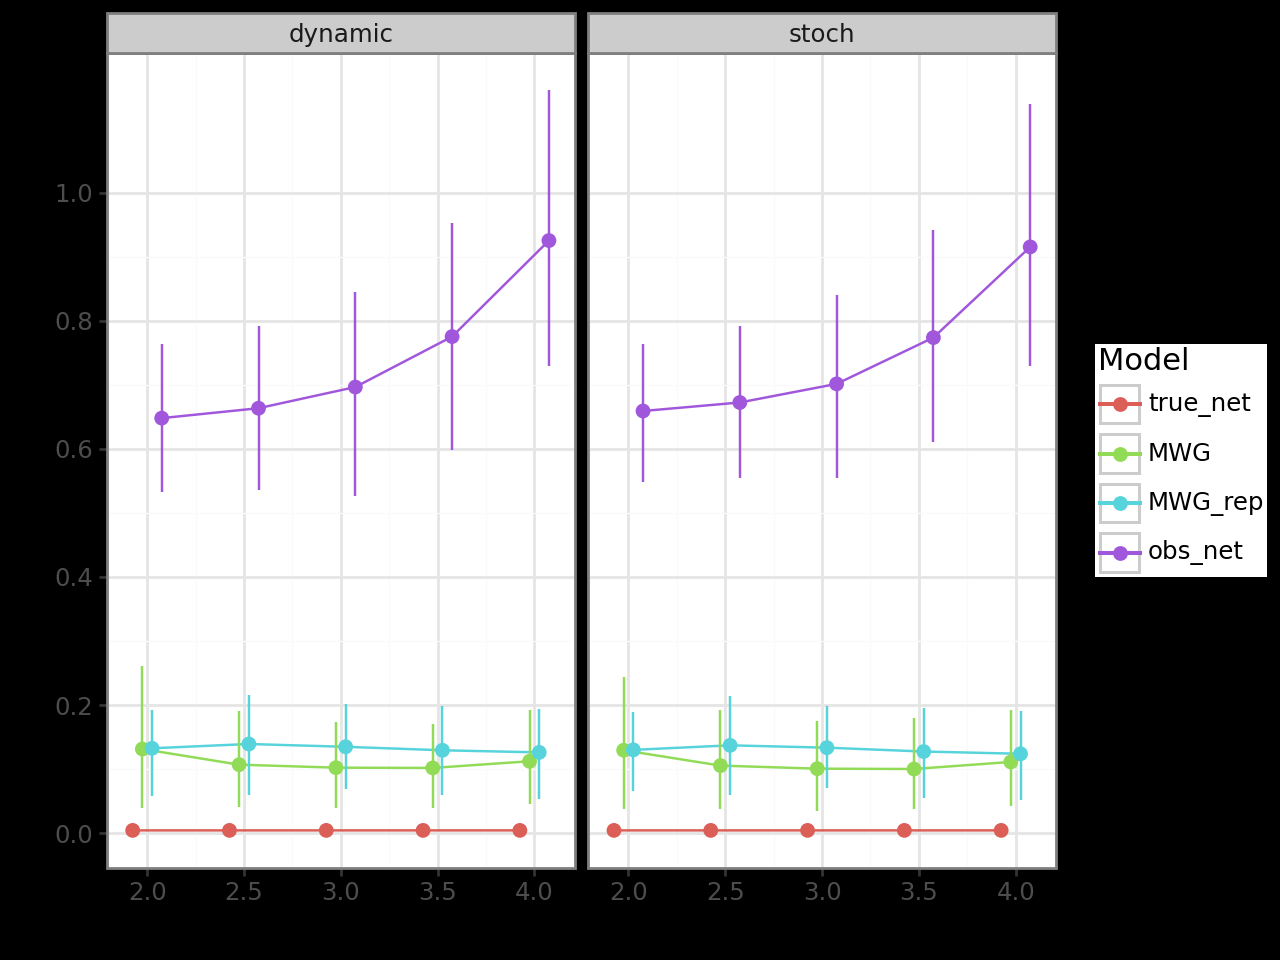

In [ ]:

results_df = pd.read_csv("Simulations/results/simulation_results_CAR_model.csv")

model_order = ["true_net", "MWG", "MWG_rep", "obs_net"]
results_df["model"] = pd.Categorical(results_df["model"], categories=model_order, ordered=True)


summary_df = (
    results_df
    .groupby(["gamma_noise", "model", "estimand"])
    .agg(
        mean_RMSE_rel=("RMSE_rel", "mean"),
        mean_RMSE_rel_std=("RMSE_rel", "std"),
        rmse_rel_q5=("RMSE_rel", lambda x: np.percentile(x, 5)),
        rmse_rel_q95=("RMSE_rel", lambda x: np.percentile(x, 95)),

        mean_MAPE = ("MAPE", "mean"),
        median_MAPE = ("MAPE", "median"),
        mean_MAPE_std = ("MAPE", "std"),
        mape_q5 = ("MAPE", lambda x: np.percentile(x, 5)),
        mape_q95 = ("MAPE", lambda x: np.percentile(x, 95)),
       
       
        cover = ("covering", "mean"),
        ind_cover = ("mean_ind_cover", "mean"),

        w_dist = ("w_dist", "mean"),

        mean = ("mean", "mean"),
        median = ("median", "median"),
        std = ("std", "mean"),
        true = ("true", "mean"),
        true_std = ("true", "std"),

        mean_975 = ("q975", "mean"),
        mean_025 = ("q025", "mean"),

        bias = ("bias", "mean"),
        bias_std = ("bias", "std"),
        )
    .reset_index()
)

summary_df["lower_rmse"] = summary_df["mean_RMSE_rel"] - summary_df["mean_RMSE_rel_std"]
summary_df["upper_rmse"] = summary_df["mean_RMSE_rel"] + summary_df["mean_RMSE_rel_std"]

summary_df["lower_mape"] = summary_df["mean_MAPE"] - summary_df["mean_MAPE_std"]
summary_df["upper_mape"] = summary_df["mean_MAPE"] + summary_df["mean_MAPE_std"]


summary_df = summary_df[summary_df["estimand"] != "estimand"]

(
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="mean_RMSE_rel", 
                                 group="model", color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2))
    
    + p9.geom_pointrange(p9.aes(
                        # ymin="lower_rmse", ymax="upper_rmse"), 
                        ymin="rmse_rel_q5", ymax="rmse_rel_q95"), 
                         position=p9.position_dodge(width=0.2),
                           )
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    + p9.labs(y="Mean RMSE rel (std)", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_y_continuous(breaks=np.arange(0, 1.2, 0.2))
    + p9.scale_color_discrete(name="Model")
)


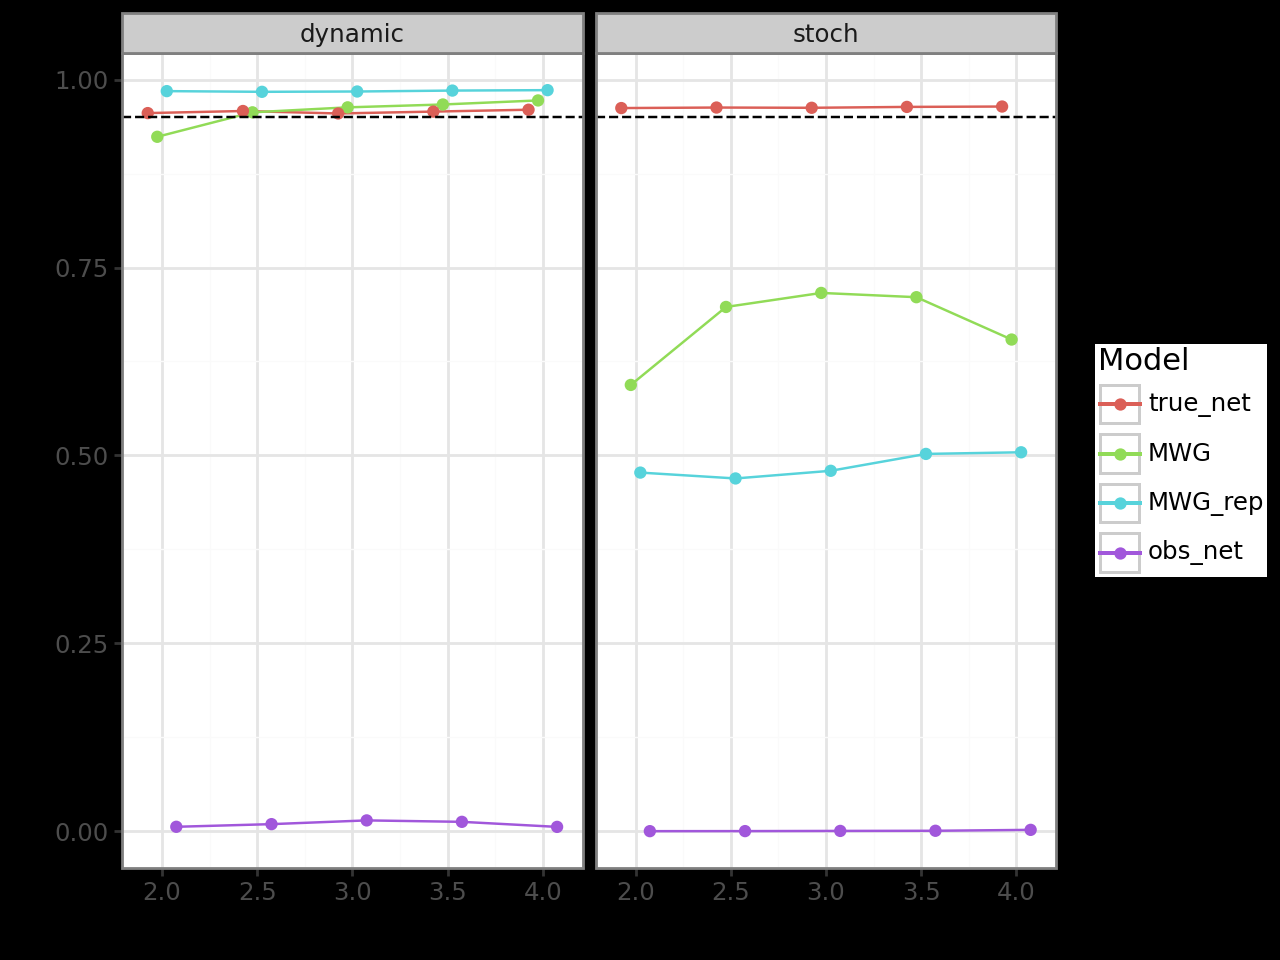

In [32]:


(
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                # y="cover", 
                                y="ind_cover", 
                                group="model",
                                color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2))
    + p9.geom_point(position=p9.position_dodge(width=0.2))
    + p9.geom_hline(yintercept=0.95, linetype="dashed")
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Coverage", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    # + p9.scale_y_continuous(breaks=np.arange(0, 1.0, 0.1))
    + p9.scale_color_discrete(name="Model")
)


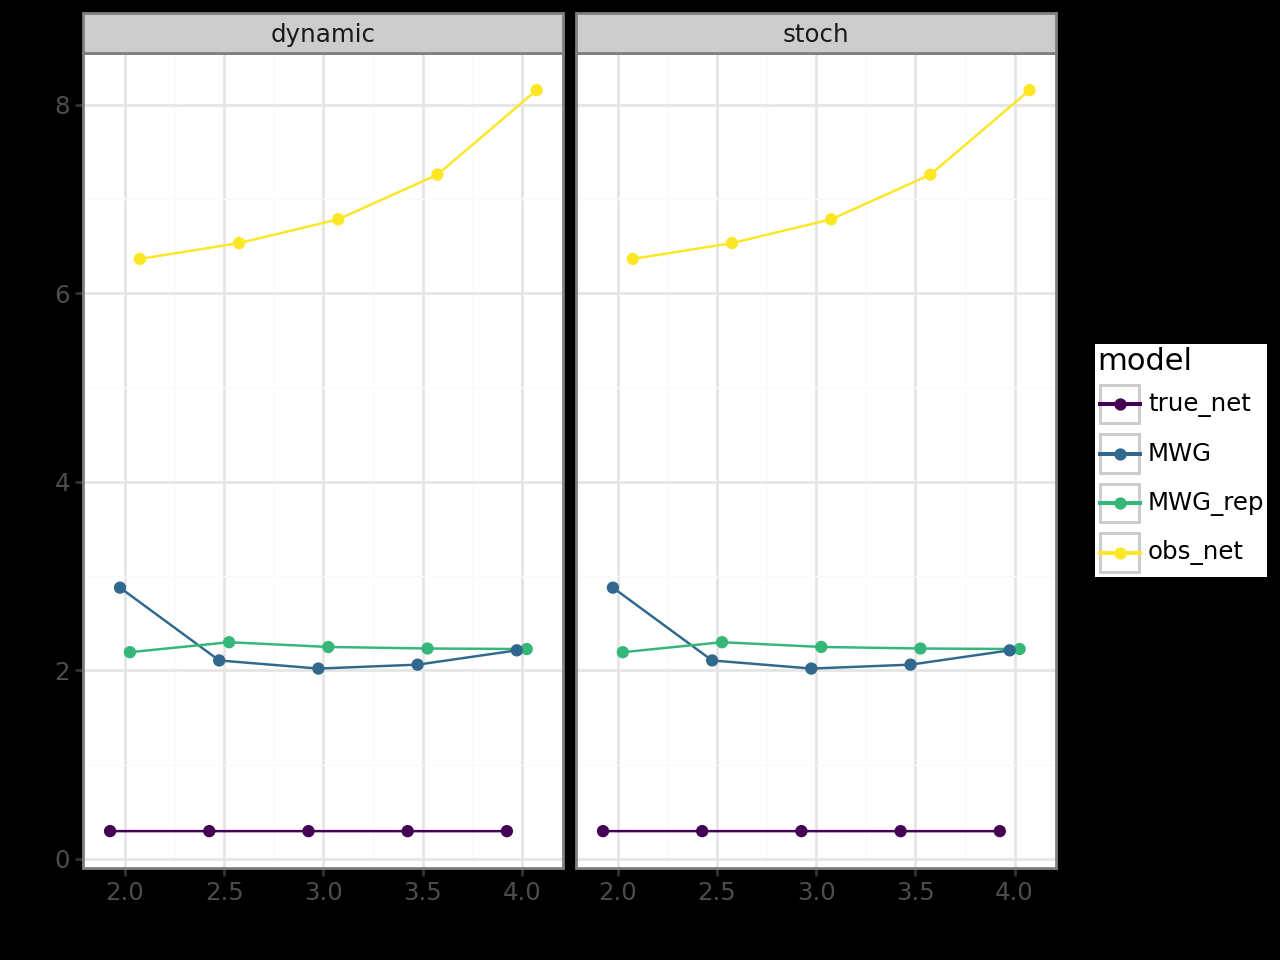

In [28]:
(
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                # y="cover", 
                                y="w_dist", 
                                group="model",
                                color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2))
    + p9.geom_point(position=p9.position_dodge(width=0.2))
    # + p9.geom_hline(yintercept=0.95, linetype="dashed")
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Coverage", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    # + p9.scale_y_continuous(breaks=n
    # p.arange(0, 1.0, 0.1))
    # + p9.scale_color_discrete(name="Model")
)


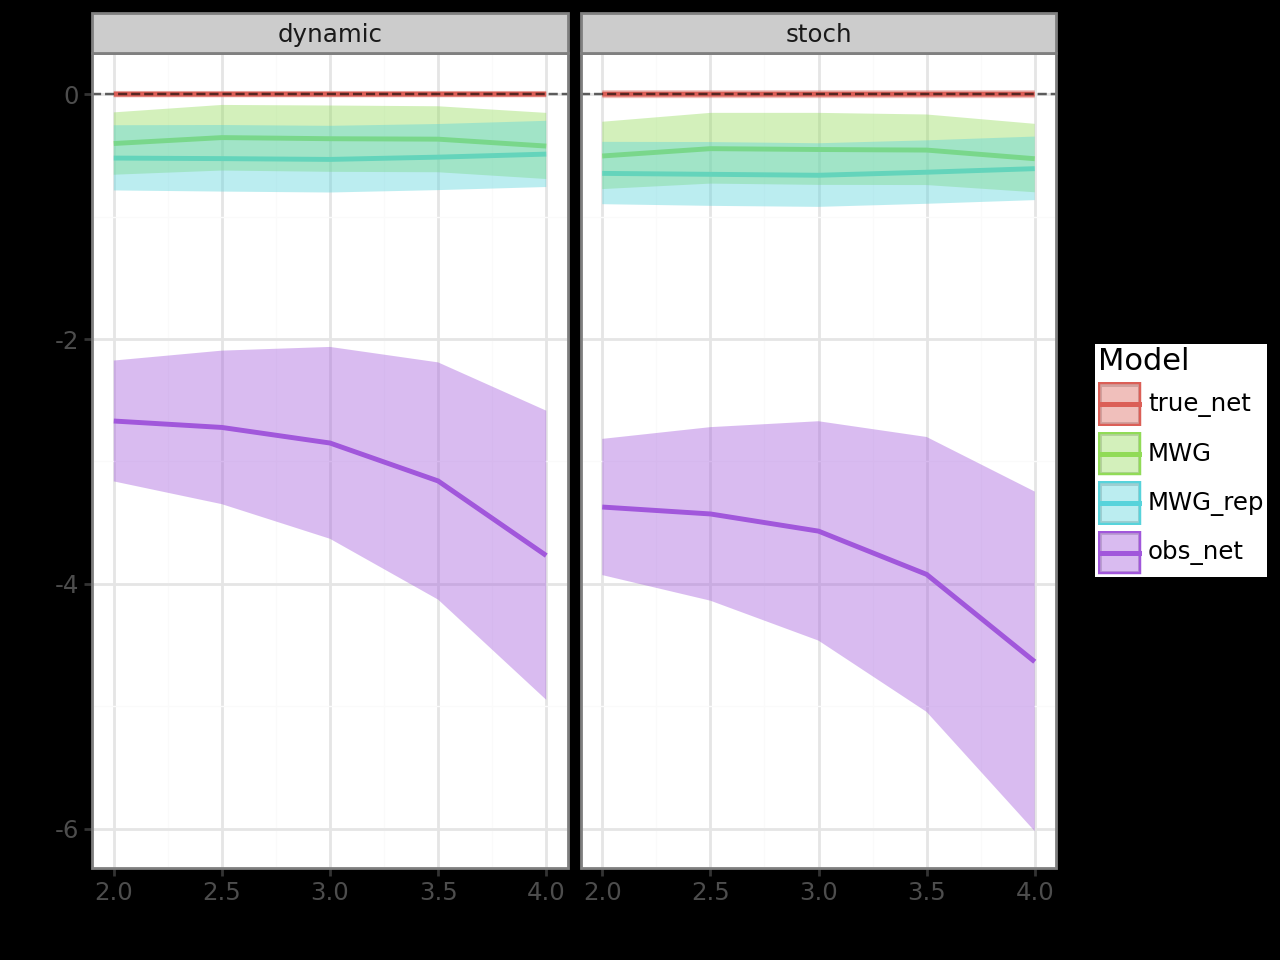

In [54]:

summary_df["mean_m_std"] = summary_df["mean"] - 2*summary_df["std"]
summary_df["mean_p_std"] = summary_df["mean"] + 2*summary_df["std"]

summary_df["true_m_std"] = summary_df["true"] - 2*summary_df["true_std"]
summary_df["true_p_std"] = summary_df["true"] + 2*summary_df["true_std"]

# summary_df["bias_m_std"] = summary_df["bias"] - 2*summary_df["bias_std"]
summary_df["bias_m_std"] = summary_df["bias"] - 2*summary_df["std"]
# summary_df["bias_p_std"] = summary_df["bias"] + 2*summary_df["bias_std"]
summary_df["bias_p_std"] = summary_df["bias"] + 2*summary_df["std"]

summary_df["bias_q975"] = summary_df["mean_975"] - summary_df["true"]
summary_df["bias_q025"] = summary_df["mean_025"] - summary_df["true"]

summary_df["bias_perc"] = summary_df["bias"] / summary_df["true"]

summary_df["bias_perc_q975"] = summary_df["bias_q975"] / summary_df["true"]
summary_df["bias_perc_q025"] = summary_df["bias_q025"] / summary_df["true"]

(
    # p9.ggplot(summary_df[summary_df["model"] != "true_net"], 
    p9.ggplot(summary_df, 
                        p9.aes(x="gamma_noise", 
                                # y="cover", 
                                # y="mean", 
                                y="bias", 
                                # y="bias_perc", 
                                # y="bias_rel", 
                                # y="median", 
                                group="model",
                                color="model",
                                fill = "model"))
    + p9.geom_line(size=1)
    # + p9.geom_ribbon(p9.aes(ymin="mean_025", ymax="mean_975"),
    # + p9.geom_ribbon(p9.aes(ymin="mean_m_std", ymax="mean_p_std"),
    # + p9.geom_ribbon(p9.aes(ymin="bias_m_std", ymax="bias_p_std"),
    + p9.geom_ribbon(p9.aes(ymin="bias_q025", ymax="bias_q975"),
    # + p9.geom_ribbon(p9.aes(ymin="bias_perc_q025", ymax="bias_perc_q975"),
    # + p9.geom_ribbon(p9.aes(ymin="bias_rel_025", ymax="bias_rel_975"),
                        #  position=p9.position_dodge(width=0.2),
                           alpha=0.4,
                         outline_type = "none")
    # + p9.geom_line(p9.aes(y="true"), linetype="dashed", color="black")
    # + p9.geom_pointrange(p9.aes(y="true", ymin="true_m_std", ymax = "true_p_std"),
                        #   linetype="dashed", color="black")
    # + p9.geom_line(p9.aes(y="true"), linetype="dashed", color="black", alpha=0.6)
    + p9.geom_hline(yintercept=0.0, linetype="dashed", color="black", alpha=0.6)
    # + p9.geom_hline(yintercept=0.95, linetype="dashed")
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Coverage", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    # + p9.scale_y_continuous(breaks=np.arange(-1.0, 0.2, 0.1))
    + p9.scale_color_discrete(name="Model")
    + p9.scale_fill_discrete(name="Model")
)